In [116]:
from writers import CSV
from analyzers import DatasetMeansAnalyzer
from datasets import TomographyArray
from utils.data_factory import DataFactory
from image_processing_pipelines import ThresholdClusterPipeline
import os

In [117]:
# Sets up a tomography to pull slices from
print("Compiling Dataset...")
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2012-09-23-53/20120923_Hylemonella_50001_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2013-01-03-21/Bdel_Hyle_0020009_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/3/Bdellovibrio_ConventionalTilt3_full.rec"
tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Caulobacter crescentus"
data = TomographyArray([tomo_path])

Compiling Dataset...
Initialized with 1 files.


In [118]:
# Sets up an analysis pipeline
print("Setting up Analysis Pipeline...")
analyzer = DatasetMeansAnalyzer()

Setting up Analysis Pipeline...


In [119]:
# Sets up a writer
print("Setting up Writer...")
writer = CSV("dataset_means_analysis.csv")

Setting up Writer...


In [120]:
print("Configuring Processor...")
batch_size = 1
data_factory = DataFactory(
    analyzer,
    writer,
    batch_size
)

Configuring Processor...


In [121]:
print("Processing Data...")
results = data_factory.process(data, "Processing Slice")

Processing Data...


Processing Slice: 100%|██████████| 1/1 [00:22<00:00, 22.26s/it]

Data saved to dataset_means_analysis.csv


Make a polynomial fitting to each list, then normalize the domain of the functions to be between 0 and 1 and plot them.

In [122]:
# This line ensures that plots are displayed within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def fit_polynomial(numbers, degree=2):
    """
    Fit a polynomial to the data using indices as x-coordinates.

    Parameters:
    - numbers: list of y-values to fit
    - degree: degree of the polynomial to fit

    Returns:
    - x: array of indices
    - y: original data
    - polynomial: polynomial function
    - x_fit: array of x values for plotting the polynomial
    - y_fit: fitted polynomial values for plotting
    """
    # Generate the index values (independent variable)
    x = np.arange(len(numbers))
    y = np.array(numbers)
    
    # Fit a polynomial of the specified degree
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    
    # Generate x values for plotting the polynomial
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = polynomial(x_fit)
    
    return x, y, polynomial, x_fit, y_fit

def plot_polynomial_fit(x, y, x_fit, y_fit, degree):
    """
    Plot the original data and the polynomial fit.

    Parameters:
    - x: array of indices (independent variable)
    - y: original data
    - x_fit: array of x values for plotting the polynomial
    - y_fit: fitted polynomial values for plotting
    - degree: degree of the polynomial to fit
    """
    # Plot the original data and the polynomial fit
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='red', label='Data Points')
    plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit (degree {degree})')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Polynomial Fit to Data')
    plt.legend()
    plt.grid(True)
    plt.show()


Testing code with some plots

In [123]:

degree = 10 # Degree of the polynomial to fit
means0 = results[tomo_path]["means_0"]
means1 = results[tomo_path]["means_1"]
means2 = results[tomo_path]["means_2"]


Now, lets try normalizing the polynomial function and plotting the normalized function

Now I want to find the creitical number nearest to the center of the image (0.5)

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

def fit_and_normalize_index(numbers, degree=2):
    """
    Fit a polynomial to the data using normalized indices as x-coordinates.

    Parameters:
    - numbers: list of y-values to fit
    - degree: degree of the polynomial to fit

    Returns:
    - normalized_polynomial: polynomial function with normalized x (as a sympy expression)
    - normalized_x: normalized x-values
    """
    # Generate the index values (independent variable)
    x = np.arange(len(numbers))
    y = np.array(numbers)

    # Normalize the index values to the range [0, 1]
    normalized_x = (x - x.min()) / (x.max() - x.min())
    
    # Fit a polynomial of the specified degree using numpy
    coefficients = np.polyfit(normalized_x, y, degree)
    # Convert coefficients to sympy expression
    x_sym = sp.symbols('x')
    normalized_polynomial = sum(c * x_sym**i for i, c in enumerate(reversed(coefficients)))

    return normalized_polynomial, normalized_x

def find_nearest_local_minimum_and_inflections(normalized_polynomial):
    """
    Find the local minimum nearest to x = 0.5 and the inflection points surrounding it.

    Parameters:
    - normalized_polynomial: normalized polynomial function (as a sympy expression)

    Returns:
    - x_min: x-coordinate of the nearest local minimum to x = 0.5
    - y_min: y-coordinate of the nearest local minimum
    - inflection_points_x: x-coordinates of the inflection points surrounding the local minimum
    - inflection_points_y: y-coordinates of the inflection points surrounding the local minimum
    """
    x_sym = sp.symbols('x')

    # Compute the first and second derivatives of the polynomial
    derivative = sp.diff(normalized_polynomial, x_sym)
    second_derivative = sp.diff(derivative, x_sym)
    
    # Solve for the critical points (where the first derivative is zero)
    critical_points = sp.solveset(derivative, x_sym, domain=sp.Interval(0, 1))
    
    if not critical_points:
        raise ValueError("No critical points found in the interval [0, 1]")

    # Convert critical points to numerical values
    critical_points = [float(point.evalf()) for point in critical_points]
    
    # Find local minima among the critical points
    minima = []
    for point in critical_points:
        if second_derivative.subs(x_sym, point) > 0:  # Check if it's a local minimum
            y_min = float(normalized_polynomial.subs(x_sym, point))
            minima.append((point, y_min))
    
    if not minima:
        raise ValueError("No local minima found in the interval [0, 1]")

    # Find the local minimum nearest to x = 0.5
    center = 0.5
    nearest_minima = min(minima, key=lambda min_point: abs(min_point[0] - center))
    x_min, y_min = nearest_minima

    # Find inflection points (where the second derivative changes sign)
    x_values = np.linspace(0, 1, 1000)
    second_derivative_func = sp.lambdify(x_sym, second_derivative, 'numpy')
    y_second_derivative = second_derivative_func(x_values)
    sign_changes = np.where(np.diff(np.sign(y_second_derivative)))[0]
    inflection_points_x = x_values[sign_changes]
    normalized_polynomial_func = sp.lambdify(x_sym, normalized_polynomial, 'numpy')
    inflection_points_y = normalized_polynomial_func(inflection_points_x)

    # Find the two inflection points surrounding the nearest local minimum
    left_inflection = inflection_points_x[inflection_points_x < x_min].max()
    right_inflection = inflection_points_x[inflection_points_x > x_min].min()

    inflection_points_x = np.array([left_inflection, right_inflection])
    inflection_points_y = normalized_polynomial_func(inflection_points_x)

    return x_min, y_min, inflection_points_x

def plot_normalized_index(numbers, normalized_polynomial, normalized_x):
    """
    Plot the polynomial with normalized indices along with the original data points,
    the nearest local minimum, and inflection points near the local minimum.

    Parameters:
    - numbers: list of original y-values
    - normalized_polynomial: polynomial function with normalized x (as a sympy expression)
    - normalized_x: normalized x-values
    """
    y = np.array(numbers)

    # Generate x values for plotting the normalized polynomial
    x_fit = np.linspace(normalized_x.min(), normalized_x.max(), 100)
    # Convert the sympy polynomial to a numpy function for evaluation
    normalized_polynomial_func = sp.lambdify(sp.symbols('x'), normalized_polynomial, 'numpy')
    y_fit = normalized_polynomial_func(x_fit)

    # Find the nearest local minimum
    x_min, y_min = find_nearest_local_minimum(normalized_polynomial)
    
    # Calculate the first and second derivatives
    x = sp.symbols('x')
    first_derivative = sp.diff(normalized_polynomial, x)
    second_derivative = sp.diff(first_derivative, x)
    
    # Convert derivatives to numpy functions for evaluation
    first_derivative_func = sp.lambdify(x, first_derivative, 'numpy')
    second_derivative_func = sp.lambdify(x, second_derivative, 'numpy')
    
    # Find inflection points (where second derivative changes sign)
    x_inflection = np.linspace(normalized_x.min(), normalized_x.max(), 1000)
    y_second_derivative = second_derivative_func(x_inflection)
    sign_change_indices = np.where(np.diff(np.sign(y_second_derivative)))[0]
    inflection_points_x = x_inflection[sign_change_indices]
    inflection_points_y = normalized_polynomial_func(inflection_points_x)

    # Plot the original data points with normalized x
    plt.scatter(normalized_x, y, color='blue', label='Original data')

    # Plot the polynomial with normalized x
    plt.plot(x_fit, y_fit, color='red', label='Fitted polynomial')

    # Plot the nearest local minimum as a green dot
    plt.scatter(x_min, y_min, color='green', zorder=5, label='Nearest Local Minimum')

    # Plot the inflection points as orange dots
    plt.scatter(inflection_points_x, inflection_points_y, color='orange', zorder=5, label='Inflection Points')

    # Add labels and legend
    plt.xlabel('Normalized Index')
    plt.ylabel('Value')
    plt.title('Polynomial Fit with Normalized Index, Nearest Local Minimum, and Inflection Points')
    plt.legend()
    plt.show()

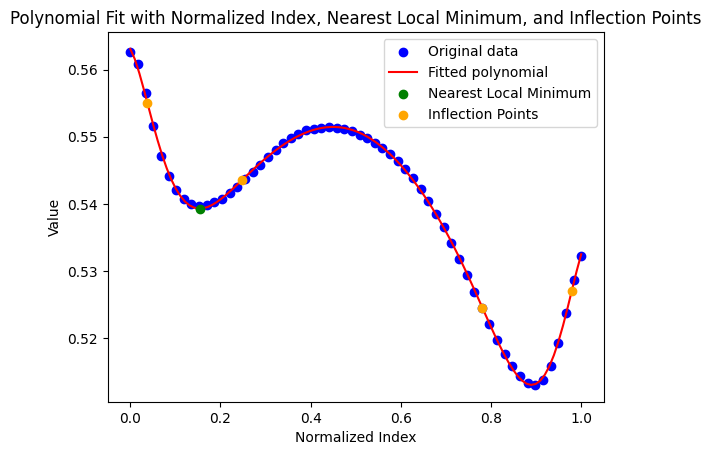

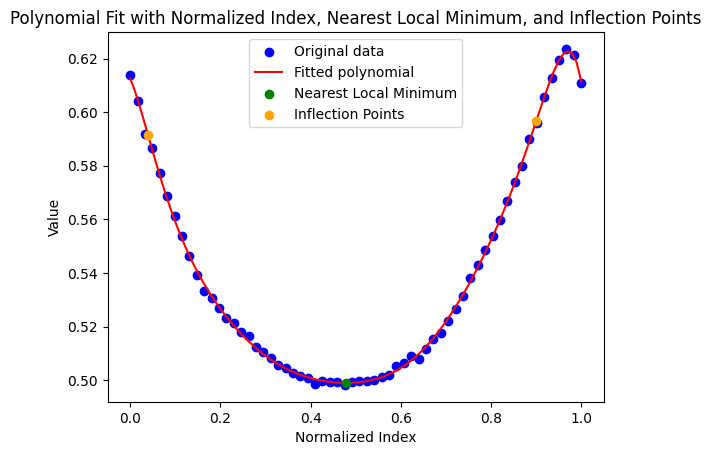

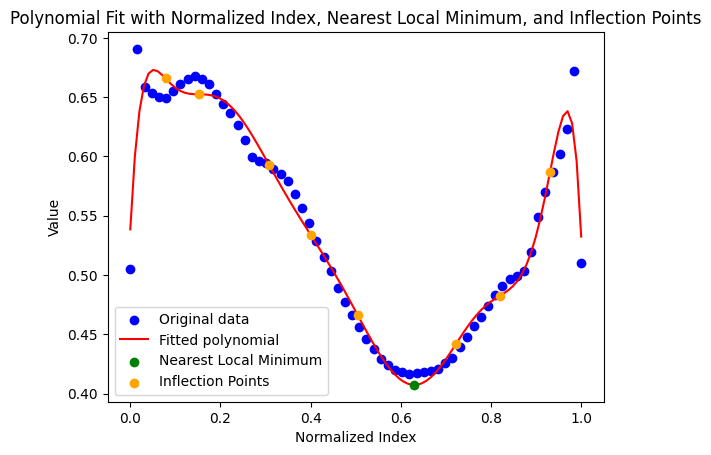

In [125]:
# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial, normalized_x = fit_and_normalize_index(means0, degree)

# Plot the polynomial with normalized index, the original points, and the local minimum
plot_normalized_index(means0, normalized_polynomial, normalized_x)

# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial, normalized_x = fit_and_normalize_index(means1, degree)

# Plot the polynomial with normalized index, the original points, and the local minimum
plot_normalized_index(means1, normalized_polynomial, normalized_x)

# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial, normalized_x = fit_and_normalize_index(means2, degree)

# Plot the polynomial with normalized index, the original points, and the local minimum
plot_normalized_index(means2, normalized_polynomial, normalized_x)


Since this is working, now I will compute the critical numbers near the center and then I will plot the dot on the actual tomogram in order to see if the value is inside the bacteria

In [126]:
# GET DATA TOMOGRAM AND FIND ALL IMPORTANT DOTS BEFORE PLOTTING
tomo = results[tomo_path]["data"]

# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial0, normalized_x = fit_and_normalize_index(means0, degree)
# Get critical numbers near the center
i_local_center0, m_local_center0, i_inflection0 = find_nearest_local_minimum_and_inflections(normalized_polynomial0)

# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial1, normalized_x = fit_and_normalize_index(means1, degree)
# Get critical numbers near the center
i_local_minima1, m_local_minima1, i_inflection1 = find_nearest_local_minimum_and_inflections(normalized_polynomial1)

# Fit the polynomial and get the normalized polynomial and normalized x values
normalized_polynomial2, normalized_x = fit_and_normalize_index(means2, degree)
# Get critical numbers near the center
i_local_minima2, m_local_minima2, i_inflection2  = find_nearest_local_minimum_and_inflections(normalized_polynomial2)



In [127]:
def plot_minima_dots(array, coord=None):
    # Get the shape of the array
    z_dim, x_dim, y_dim = array.shape

    # Determine the coordinate to plot
    if coord is None:
        coord = (z_dim // 2, x_dim // 2, y_dim // 2)
    z, x, y = coord
    
    print(z, x, y)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the XY slice (constant Z)
    axes[0].imshow(np.mean(array[z[0]:z[0]+15, :, :], axis=0), cmap='gray', origin='lower')
    axes[0].scatter(y[0], x[0], color='green', s=100)
    axes[0].scatter(y[1], x[0], color='yellow', s=25)
    axes[0].scatter(y[2], x[0], color='yellow', s=25)
    axes[0].scatter(y[0], x[1], color='yellow', s=25)
    axes[0].scatter(y[0], x[2], color='yellow', s=25)
    axes[0].set_title(f'XY Slice (Z={z[0]})')
    axes[0].set_xlabel('Y')
    axes[0].set_ylabel('X')

    # Plot the YZ slice (constant X)
    axes[1].imshow(np.mean(array[:, x[0]:x[0]+15, :], axis=1), cmap='gray', origin='lower')
    axes[1].scatter(y[0], z[0], color='green', s=100)
    axes[1].scatter(y[1], z[0], color='yellow', s=25)
    axes[1].scatter(y[2], z[0], color='yellow', s=25)
    axes[1].scatter(y[0], z[1], color='yellow', s=25)
    axes[1].scatter(y[0], z[2], color='yellow', s=25)
    axes[1].set_title(f'ZY Slice (X={x[0]})')
    axes[1].set_xlabel('Y')
    axes[1].set_ylabel('Z')

    # Plot the XZ slice (constant Y)
    axes[2].imshow(np.mean(array[:, :,y[0]:y[0]+15], axis=2), cmap='gray', origin='lower')
    axes[2].scatter(x[0], z[0], color='green', s=100)
    axes[2].scatter(x[1], z[0], color='yellow', s=25)
    axes[2].scatter(x[2], z[0], color='yellow', s=25)
    axes[2].scatter(x[0], z[1], color='yellow', s=25)
    axes[2].scatter(x[0], z[2], color='yellow', s=25)
    axes[2].set_title(f'ZX Slice (y={y[0]})')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Z')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

[150, 11, 74] [444, 36, 834] [603, 483, 692]


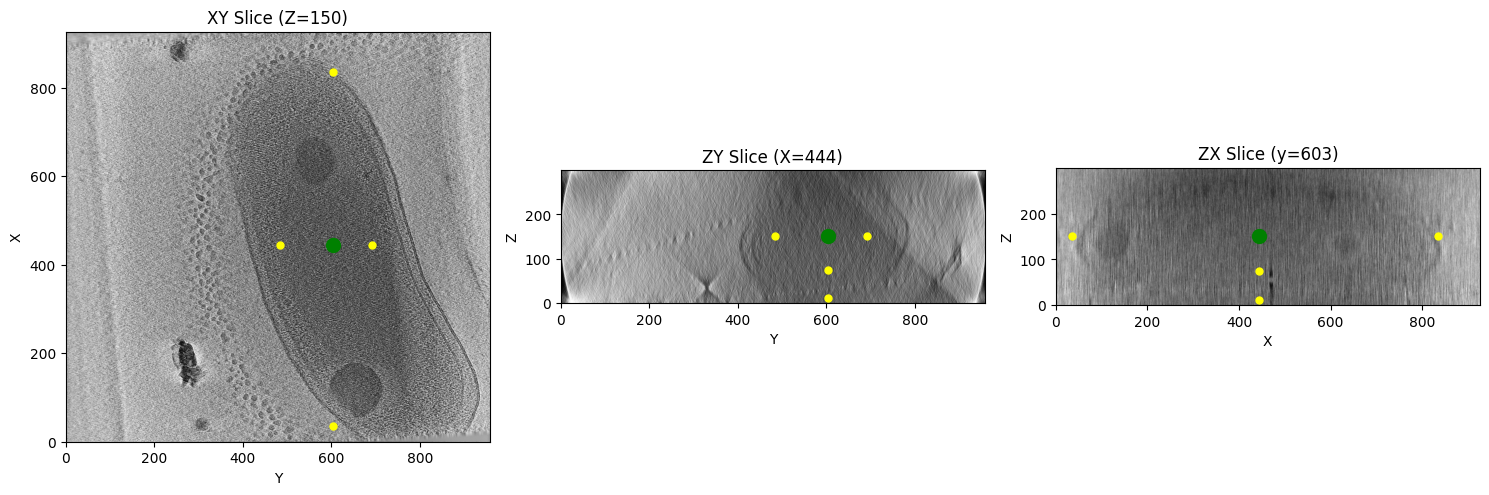

In [132]:
# transform the local minima index to be a valid coordinate
#z_points = [int(i_local_center0 * tomo.shape[0]), int(i_inflection0[0] * tomo.shape[0]), int(i_inflection0[1] * tomo.shape[0])]
z_points = [int(0.5 * tomo.shape[0]), int(i_inflection0[0] * tomo.shape[0]), int(i_inflection0[1] * tomo.shape[0])]
x_points = [int(i_local_minima1 * tomo.shape[1]), int(i_inflection1[0] * tomo.shape[1]), int(i_inflection1[1] * tomo.shape[1])]
# x_points = [int(i_local_minima1 * tomo.shape[1]), int(i_inflection1[0] * tomo.shape[1]), int(i_inflection1[1] * tomo.shape[1])]
y_points = [int(i_local_minima2 * tomo.shape[2]), int(i_inflection2[0] * tomo.shape[2]), int(i_inflection2[1] * tomo.shape[2])]
# y_points = [int(i_local_minima2 * tomo.shape[2]), int(i_inflection2[0] * tomo.shape[2]), int(0.7 * tomo.shape[2])]


plot_minima_dots(tomo, coord=(z_points, x_points, y_points))